https://docs.pymc.io/notebooks/GLM-linear.html
https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal

$$
f(x) = x^T b \quad \text{and} \quad y = f(x) + \varepsilon, \quad \text{with} \quad \varepsilon \sim N(0, \sigma_n)
$$

## Prepare Notebook

In [1]:
import scipy.stats as ss
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline


## Generate Sample Data

In [2]:
# Define dimension.
d = 2

# Number of samples. 
n = 100

# Independent variable. 
x = np.linspace(start=0, stop=1, num=n).reshape([1, n])

# Design matrix. 
X = np.append(np.ones(n).reshape([1, n]), x, axis=0)

# True parameters. 

b = np.zeros(d)
## Intercept. 
b[0] = 1
## Slope. 
b[1] = 3

b = b.reshape(d, 1)

# Error standar deviation. 
sigma_n = 0.5

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n).reshape([n, 1])

f = np.dot(X.T, b)

# Observer target variable. 
y = f + epsilon

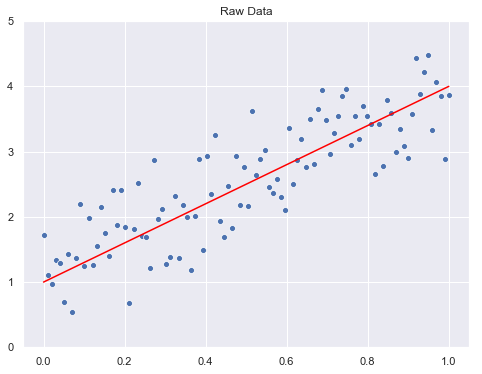

In [3]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red");

ax.set_ylim((0,5));
ax.set_title("Raw Data");

## Prior Distribution

$$
p(y|X, b) = 
\frac{1}{(2\pi \sigma_n^2)^{n/2}} \exp\left(-\frac{1}{2\sigma_n^2}||y - X^T b||^2\right) = 
N(X^T b, \sigma_n^2 I)
$$

$$
b \sim N(0, \Sigma_p)
$$

In [4]:
mu_0 = np.zeros(d)

sigma_p = np.array([[2, 1], [1, 2]]) + 1e-12*np.eye(d)

/Users/juanitorduz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


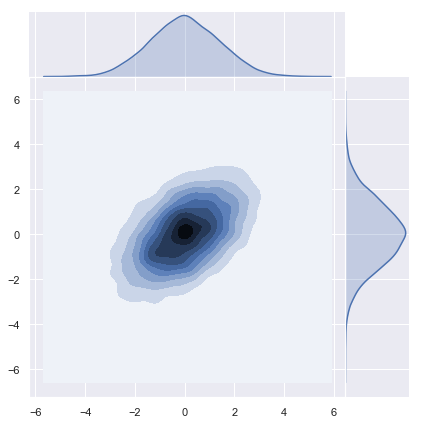

In [5]:
m = 10000

z = np.random.multivariate_normal(mean=mu_0, cov=sigma_p, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

## Posterior Distribution

$$
\text{posterior} =
\frac{\text{likelihood × prior}}{\text{marginal likelihood}}
$$

$$
p(b|y, X) = 
\frac{p(y|X, b)p(b)}{p(y|X)}
$$

$$
p(y|X) = \int p(y|X, b)p(b) db
$$

### MCMC Sampling with PyMC3

In [6]:
import theano.tensor as tt

model = pm.Model()

with model:
    
    # Define prior.
    beta = pm.MvNormal("beta", mu=mu_0, cov=sigma_p, shape=d)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=tt.dot(X.T, beta), sd=sigma_n, observed=y.squeeze())
    
    # Consider 6000 draws and 3 chains.
    trace = pm.sample(draws=6000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta]
Sampling 3 chains: 100%|██████████| 19500/19500 [00:09<00:00, 1998.14draws/s]


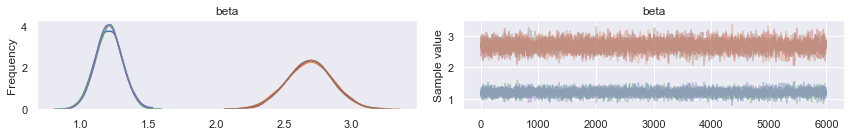

In [7]:
pm.traceplot(trace);

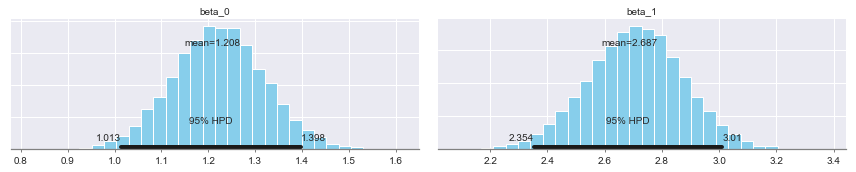

In [8]:
pm.plot_posterior(trace);

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,1.208428,0.098017,0.001384,1.012661,1.397581,4518.930845,1.000116
beta__1,2.687299,0.168269,0.002353,2.353515,3.010297,4585.368648,1.000157


/Users/juanitorduz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


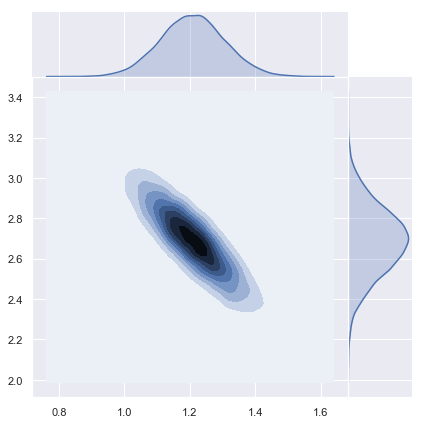

In [10]:
sns.jointplot(x=trace["beta"].T[0],
              y=trace["beta"].T[1], 
              kind="kde", 
              space=0);

### Analytical Solution

$$
p(b|y, X) \propto 
\exp\left(
-\frac{1}{2\sigma_n^2}||y - X^T b||^2
\right)
\exp\left(
-\frac{1}{2} b^T \Sigma_p b
\right)
$$

$$
A:= \sigma_n^{-2}XX^T + \Sigma_p^{-1} \in M_{d}(\mathbb{R})
\quad
\text{and}
\quad
\bar{b}:= \sigma_n^{-2}AXy
$$

In [11]:
A = (sigma_n)**(-2)*np.dot(X, X.T) + np.linalg.inv(sigma_p)
A_inv = np.linalg.inv(A)

In [12]:
b_bar = (sigma_n)**(-2)*np.dot(A_inv, np.dot(X, y))
b_bar

array([[1.20787503],
       [2.68754393]])

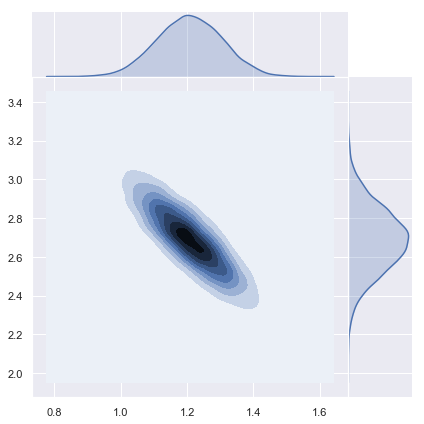

In [13]:
m = 10000

z = np.random.multivariate_normal(mean=b_bar.squeeze(), cov=A_inv, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

## Predictions

### Parameter Mean

In [14]:
beta_hat = (np.apply_over_axes(func=np.mean, a=trace["beta"], axes=0)
            .squeeze()
            .reshape(d,1))

y_hat = np.dot(X.T, beta_hat)

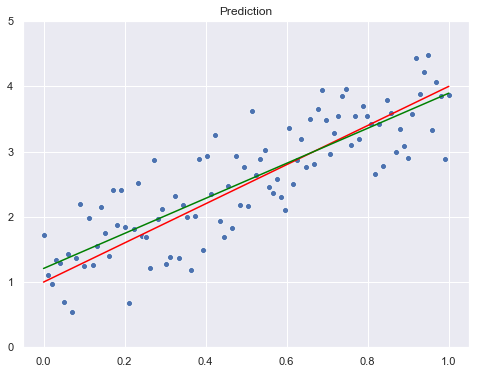

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red");

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

ax.set_ylim((0,5));
ax.set_title("Prediction");

### Confidence Inteval 

In [16]:
y_hat_samples = np.dot(X.T, trace["beta"].T)

In [17]:
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

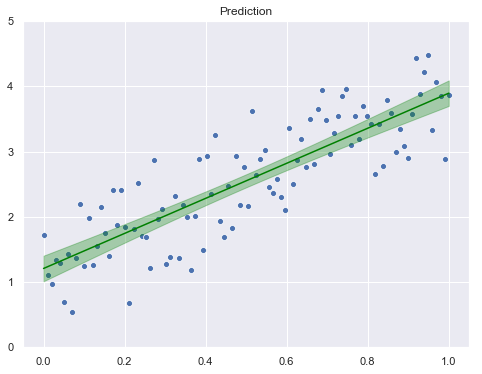

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

ax.set_ylim((0,5));
ax.set_title("Prediction");

### Test Set

In [19]:
def generate_prediction(x_star):

    prob = np.dot(x_star.T, trace["beta"].T)

    y_hat = np.random.choice(a=prob.squeeze())
    
    return y_hat

In [20]:
x_star = np.array([[1], [0.85]])

y_hat_star = generate_prediction(x_star)

y_hat_star

3.510333544438188

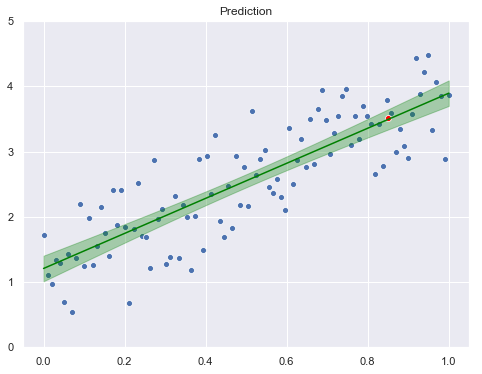

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

sns.scatterplot(x=x_star[1], y=y_hat_star, color="red");


ax.set_ylim((0,5));
ax.set_title("Prediction");